<p style="text-align:center">
    <a href="https://nbviewer.jupyter.org/github/twMr7/Python-Machine-Learning/blob/master/15-Machine_Learning_with_Scikit.ipynb">
        Open In Jupyter nbviewer
        <img style="float: center;" src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" width="120" />
    </a>
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/Python-Machine-Learning/blob/master/15-Machine_Learning_with_Scikit.ipynb)

# 15. Machine Learning with Scikit

**Scikit-learn** 提供了簡單有效率的資料分析工具，其中整合了相當多在執行機器學習任務過程所需要的套件：
+ 資料前處理： 數據正規化、類別欄位轉數值。
+ 特徵工程： 特徵選取、特徵萃取、特徵降維。
+ 學習模型： Classification/Regression, Parametric/Non-Parametric, Supervised/Unsupervised, ... 等方法。
+ 模型選取： 交叉驗證、超參數搜尋、效能度量指標。

本章節主要內容，介紹如何利用 scikit-learn 的工具來完成機器學習的任務流程。 按照一般機器學習專案的開發順序，一開始介紹準備資料時需要做的資料集切割、交叉驗證，前處理的數據正規化， ...

| 工具函式庫套件      | 網址                                                                    |
|---------------------|-------------------------------------------------------------------------|
| **`pandas`**        | [pandas.pydata.org](https://pandas.pydata.org/docs/reference/index.html)|
| **`matplotlib`**    | [matplotlib.org](https://matplotlib.org/stable/contents.html)           |
| **`seaborn`**       | [seaborn.pydata.org](https://seaborn.pydata.org/)                       |
| **`scikit-learn`**  | [scikit-learn.org](https://scikit-learn.org/stable/modules/classes.html)|

+ [**15.1 資料集切割與交叉驗證**](#cross-validation)
+ [**15.2 數據正規化**](#data-normalization)
+ [**15.3 將工作流程封裝成 Pipeline**](#task-pipeline)
+ [**15.4 效能評估指標**](#performance-metrics)
+ [**參考資料**](#references)

In [1]:
# 預載入必要模組與環境設定
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# 輔助圖片顯示及嵌入 notebook
from IPython.display import Image

<a id="cross-validation"></a>

## 15.1 資料集切割與交叉驗證

在之前的章節中提到過，我們希望機器學習訓練出來的模型具有泛化能力，在上線輸入真實世界的資料時仍然維持相同的預測效能。 為了在訓練過程就能模擬真實世界面臨沒見過的新資料的狀況，在開始訓練模型之前會先把資料集做切割，保留一小部分當測試集，剩下的是訓練模型用的訓練集。


### § 資料集切割

切割成兩份的大小如何分配？ 目前沒有一個固定有效的評估標準。 機器學習裡有幾種常見的的比例分配，如 **train：test = 7:3**、**8:2**、或**9:1**等等，如何決定分配的比例取決於資料集的大小。 一般來說，訓練集越多模型學得越好，但測試集太小也不能反映真實的狀況。 例如一個 600 筆的資料集，按照 9:1 的比例分配是 540:60 筆，直覺判斷可能會覺得測試集有點少，而按照 7:3 的比例分配是 420:180 筆，可能又會覺得訓練集太小。 但如果是 1000,000 筆的資料集，按照 9:1 的比例應該會覺得測試集可以再少一點，例如 20,000 筆的測試集可能就夠多了。


#### ★ 測試集要有代表性 ★

測試集一定要盡可能反映模型實際使用的狀況。 不僅僅是樣本數量大小夠不夠的問題而已，要注意所選出來的測試集裡：
1. **各類別的分布狀況是否符合實際使用狀況？**
2. **所輸入的特徵數據是否符合實際使用狀況？**

例如： 生產線上的瑕疵檢測，實際狀況常常是瑕疵的資料比正常的資料少很多，所以訓練資料常常呈現極度不平衡的比例分布狀況。 如果使用大多數是瑕疵的資料來當測試集，實際上線時可能會發現 *false positive* 的誤判過高。 這非常可能就是訓練過程不符合實際狀況的測試誤導的，因為大量的瑕疵鼓勵了模型這樣的判斷可以得高分。

例如： 深度學習裡常見的手法，在訓練資料太少時，採用 *Data Augmentation* 的手法來擴充資料時常是有效的。 據說有使用 webcam 偵測室內公共場所人群的模型，在訓練集裡加入了大量網路上抓來的圖片，結果證實是有助於模型學習出更好的辨識能力的。 像這樣擴充資料的方式，在測試集裡就應該避免放進網路抓來的圖片，也應該避免室外、路上、野外的拍攝場景，應該就只使用符合實際使用的目標情境下的影像。



Scikit-learn 在 [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) 模組裡，提供了一個可以指定比例來做 train/test 分割的工具函式。
+ [**`train_test_split()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)。 


In [3]:
# 生成 10x2 大小的 X，以及對應的 10 個 y 數列
X = np.arange(20).reshape((10, 2)) 
y = np.arange(10)

print('X =\n', X)
print('y =\n', y)

X =
 [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
y =
 [0 1 2 3 4 5 6 7 8 9]


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print('X_train =\n', X_train)
print('y_train =\n', y_train)
print('X_test =\n', X_test)
print('y_test =\n', y_test)

X_train =
 [[16 17]
 [ 2  3]
 [ 6  7]
 [10 11]
 [ 4  5]
 [12 13]]
y_train =
 [8 1 3 5 2 6]
X_test =
 [[ 8  9]
 [14 15]
 [ 0  1]
 [18 19]]
y_test =
 [4 7 0 9]


In [5]:
train_test_split(y, test_size=0.3, shuffle=False)

[array([0, 1, 2, 3, 4, 5, 6]), array([7, 8, 9])]

### § 交叉驗證 Cross-Validation

資料切割成訓練集跟測試集，也確認測試集符合實際狀況，那就可以直接拿訓練集來訓練模型，拿測試集來測試訓練後的模型效能了。

Wait a minute，ちょっと待ってください，**請等一下**。

機器學習模型的演算法都需要給適合的**超參數（hyperparameters）**，而且不是任何資料都適用同一組超參數。 實務上，針對一項機器學習任務的開發，我們會使用不同的超參數組合來分別訓練模型，再從測試這些模型的結果來決定最適合的超參數。 這個挑選的過程通常會由程式迭代自動反覆進行，如果使用測試集進行超參數的評估，所選的超參數仍然有可能是針對測試集過度擬合的結果，因為測試集已經洩漏了評估的結果，使得這個過程傾向於挑選讓模型過度擬合測試集的指標分數，因此所評估的效能指標已經沒辦法公正地代表泛化的程度。

什麼？ 不測試不準，測試也不準，是在哈囉！

為了解決這樣的問題，訓練模型的超參數挑選過程不使用測試集，會從訓練集裡面再保留一部份當作評估效能的驗證集（validation set）。 驗證完挑選了適當超參數後，使用這組超參數整個訓練集重新訓練一次，再跟測試集測試取得最後模型的效能指標。 所以典型的模型訓練就變成如下圖的流程。


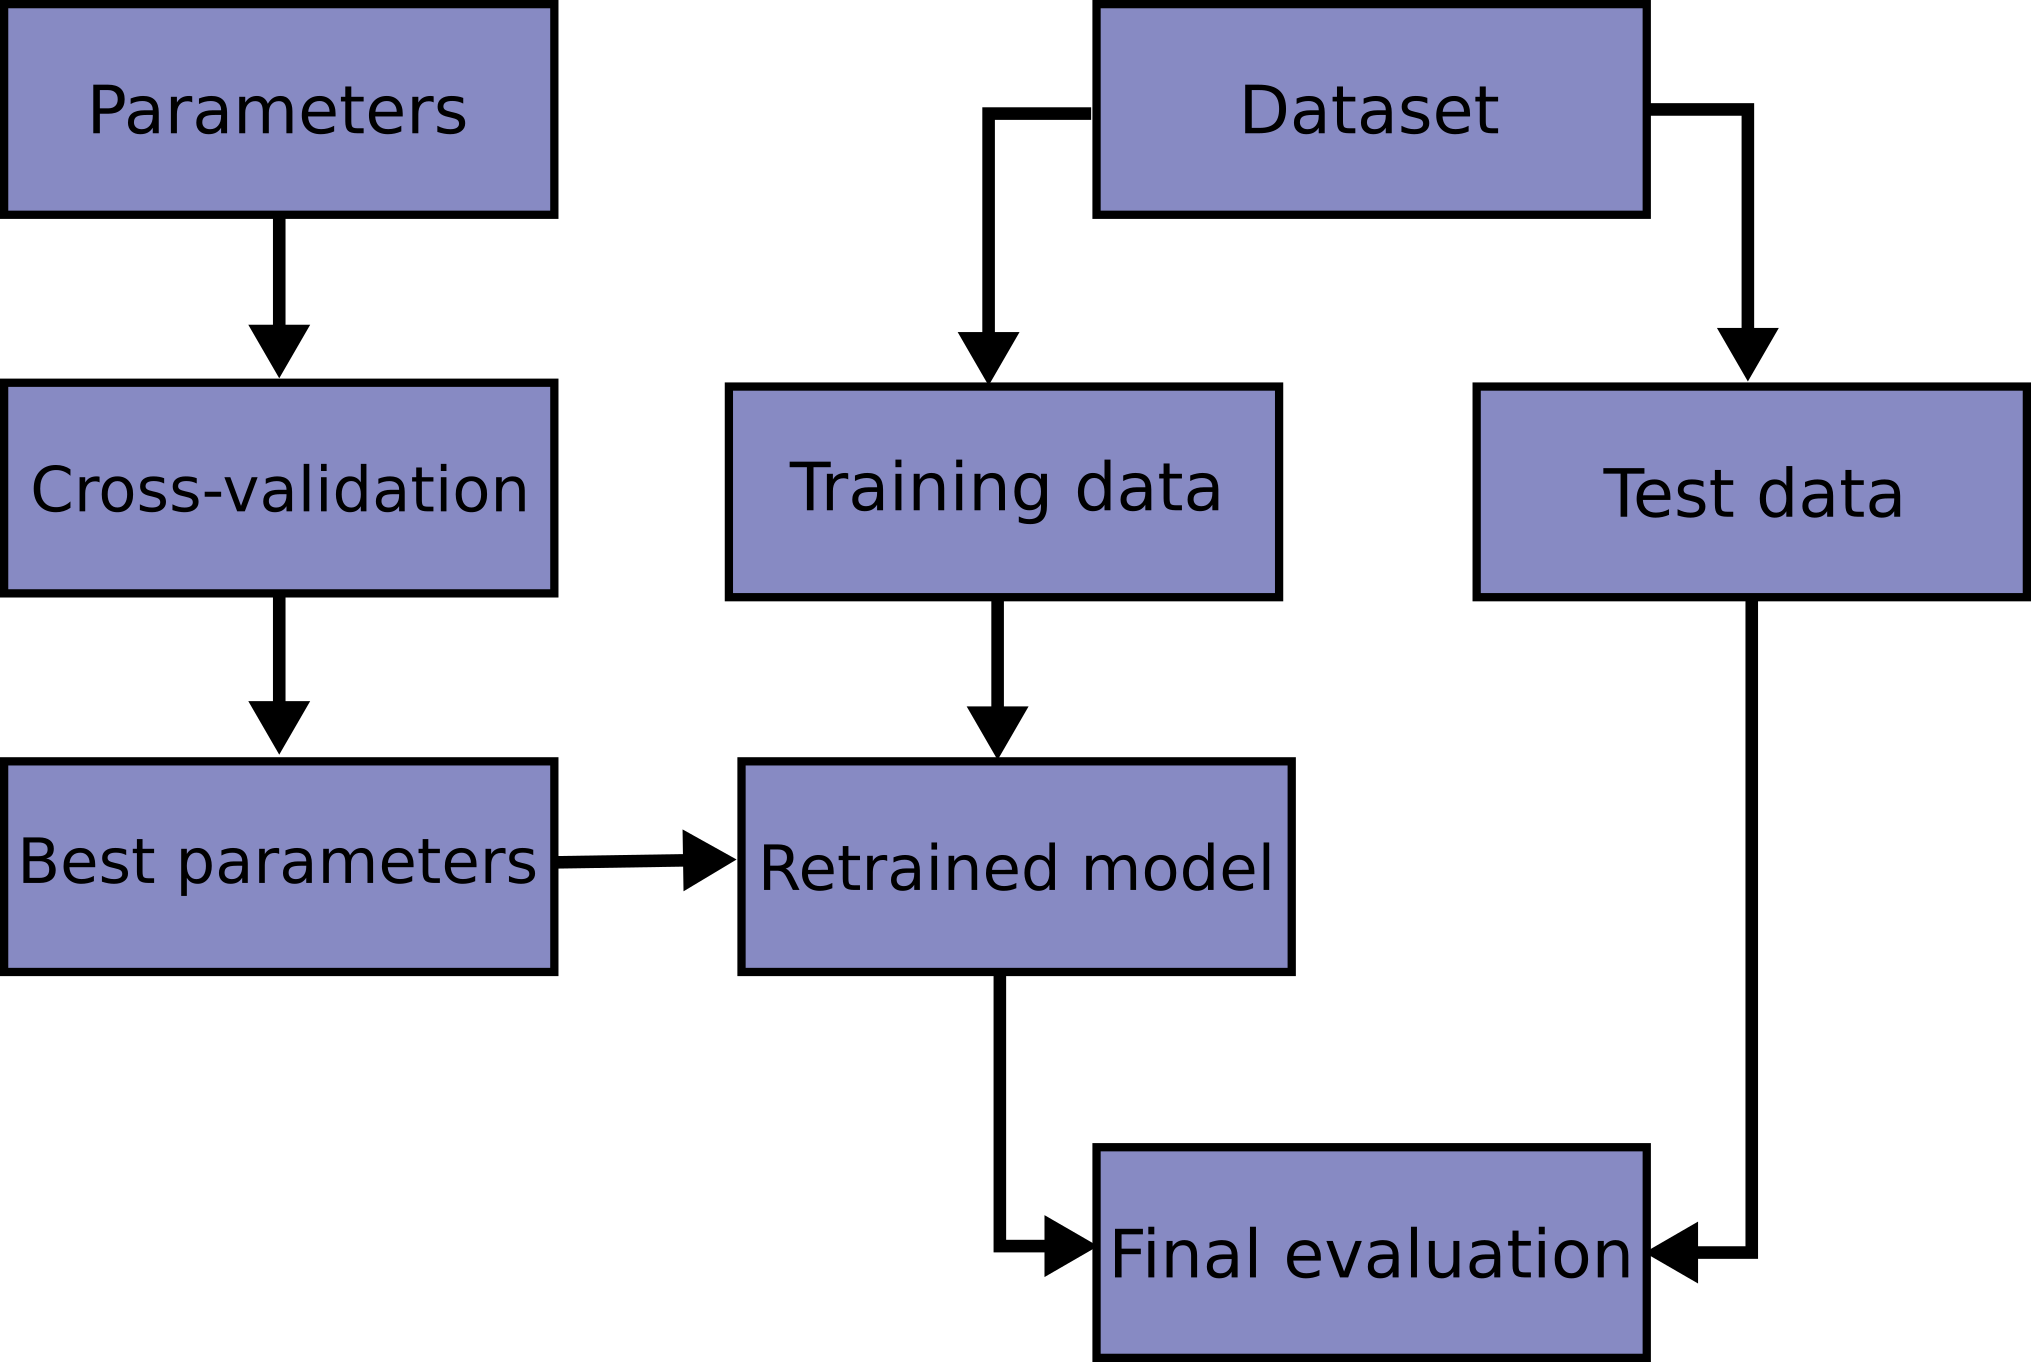

In [6]:
# 典型的模型訓練流程圖
Image(url='https://scikit-learn.org/stable/_images/grid_search_workflow.png', embed=True, width=480)

#### ★ K-fold Cross-Validation ★

時常訓練集都已經不是很夠了，還要再保留一部分作驗證集那不是訓練集又變得更小了。 簡單直覺的解決方案就是： **全部的訓練集資料都分階段輪流當訓練集和驗證集**。 這個概念就是所謂的**交叉驗證（Cross-Validation）**，不用特別再保留一份當驗證集。 基本的做法就是把訓練集拆成 k 等份，每次都只保留其中某一份作驗證，其餘的作訓練，全部 k 個等份都同樣輪流作一次，然後把 k 次的結果作平均。 這樣就所有的資料都有訓練過也驗證過，這種交叉驗證的手法我們稱為 **k-Fold Cross-Validation**。 一般常見 5-fold 或 10-fold 交叉驗證，但跟資料集切割一樣，k 是多少取決於資料集的大小跟資料特性，並沒有一體適用的方式。

由於 k-fold 交叉驗證會花比較久的時間運算，所以如果輸入資料是像語音、影像這種大型的數據，而且是有百萬筆等級的資料集，隨機抽樣 1% 都還有個一萬筆，那就不必一定要切割成 k 等份，隨機取適當數量的驗證集作驗證即可。

有一種比較極端狀況的交叉驗證，當訓練資料很少時，可以每次只保留一筆作驗證，總共有 m 筆訓練資料的話，k-fold 就要做 m 次，這個方法叫做 **Leave One Out**。


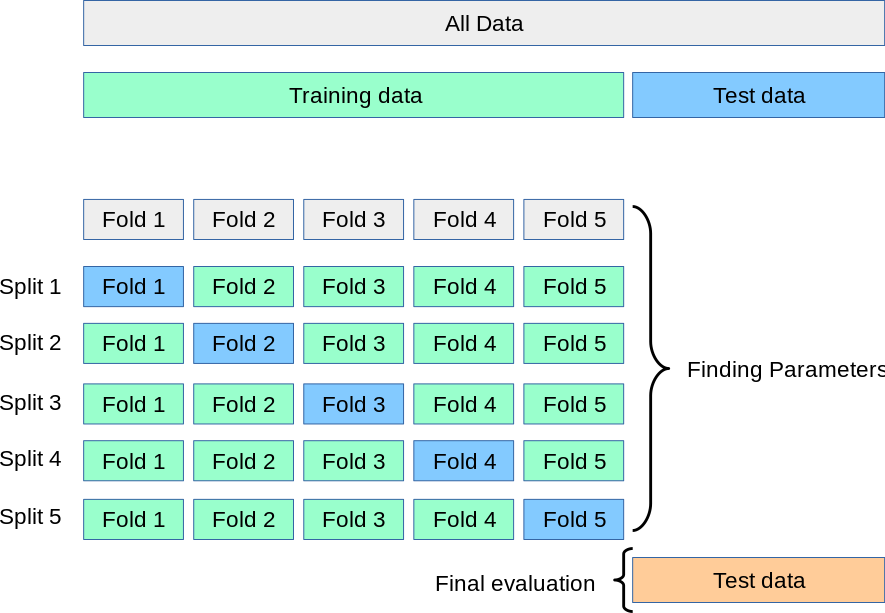

In [6]:
# k-fold 交叉驗證
Image(url='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png', embed=True, width=480)


在 `sklearn.model_selection` 模組中，提供了好幾種用來交叉驗證的不同 k-fold 分割的迭代類別，這些類別都會提供一個 `split()` 的生成函數，被呼叫時會回傳 k 等份的資料序號。 常用的如下：

+ [**`KFold()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) - 一般的 k 等份分割。
+ [**`RepeatedKFold()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html) - 重覆 n 次的 k 等份分割。
+ [**`StratifiedKFold()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) - 分割方式會維持每種類別的數量比例。
+ [**`RepeatedStratifiedKFold()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) - 重覆 n 次的維持類別比例分割。
+ [**`LeaveOneOut()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) - 每次都只留一筆驗證。
+ [**`ShuffleSplit()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) - 每次隨機排列的分割，是會重複取樣的方式。
+ [**`StratifiedShuffleSplit()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) - 每次維持類別比例的隨機排列分割。


In [7]:
# 生成 10x2 大小的 X，以及對應的 10 個 y 數列
X = np.arange(20).reshape((10, 2))
y = np.zeros(10)
y[6:] = 1.0

print('X =\n', X)
print('y =\n', y)

X =
 [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
y =
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [8]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3)
for k, (train_index, test_index) in enumerate(kfold.split(X, y)):
    print('>> Fold #', k)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(' - Train index:', train_index, '\n - X:', X_train, '\n - y:', y_train, '\n')
    print(' - Test index:', test_index, '\n - X:', X_test, '\n - y:', y_test, '\n')

>> Fold # 0
 - Train index: [4 5 6 7 8 9] 
 - X: [[ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]] 
 - y: [0. 0. 1. 1. 1. 1.] 

 - Test index: [0 1 2 3] 
 - X: [[0 1]
 [2 3]
 [4 5]
 [6 7]] 
 - y: [0. 0. 0. 0.] 

>> Fold # 1
 - Train index: [0 1 2 3 7 8 9] 
 - X: [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [14 15]
 [16 17]
 [18 19]] 
 - y: [0. 0. 0. 0. 1. 1. 1.] 

 - Test index: [4 5 6] 
 - X: [[ 8  9]
 [10 11]
 [12 13]] 
 - y: [0. 0. 1.] 

>> Fold # 2
 - Train index: [0 1 2 3 4 5 6] 
 - X: [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]] 
 - y: [0. 0. 0. 0. 0. 0. 1.] 

 - Test index: [7 8 9] 
 - X: [[14 15]
 [16 17]
 [18 19]] 
 - y: [1. 1. 1.] 



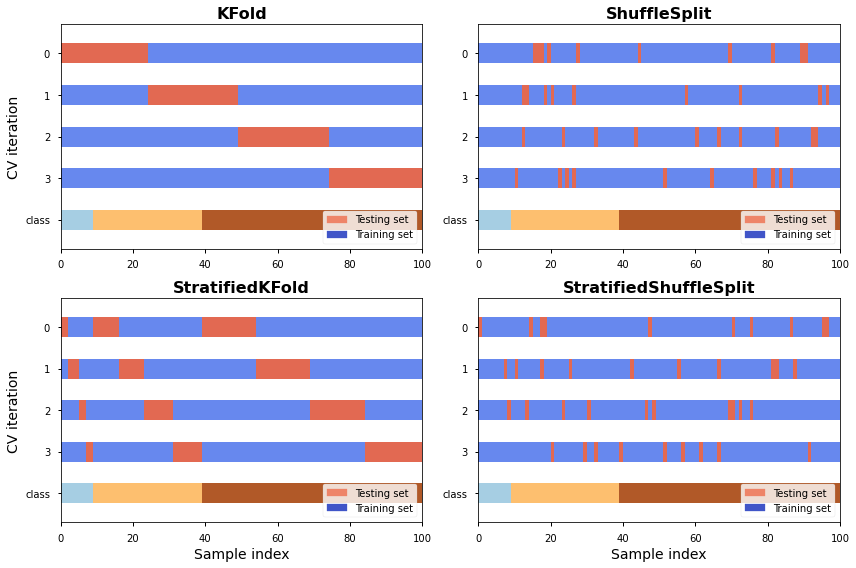

In [9]:
# 生成 100 個新的範例資料點
n_points = 100
X = np.random.randn(100, 10)

# y 包含三個分布非常不平衡的類別
percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[c] * int(100 * perc) for c, perc in enumerate(percentiles_classes)])

# 要顯示的不同類別
from sklearn.model_selection import (
    KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
)
cvs = [KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit]
n_splits = 4

# 用圖顯示不同 k-fold 類別的分割分配
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
x_lim = [0, n_points]
y_lim = [n_splits+1.2, -0.2]
y_ticks = np.arange(n_splits+1) + 0.5
y_ticklabels = list(range(n_splits)) + ['class']

from matplotlib.patches import Patch

for n, (cv, ax) in enumerate(zip(cvs, axs.reshape(-1))):
    cv_n = cv(n_splits=n_splits)
    for k, (idxtrain, idxtest) in enumerate(cv_n.split(X=X, y=y)):
        indices = np.zeros(X.shape[0])
        indices[idxtest] = 1.0
        ax.scatter(range(X.shape[0]), [k+0.5] * X.shape[0],
                   c=indices, marker='_', lw=20, cmap=cmap_cv,
                   vmin=-0.2, vmax=1.2)

    # Plot the data classes at the end
    ax.scatter(range(X.shape[0]), [k + 1.5] * X.shape[0],
               c=y, marker='_', lw=20, cmap=cmap_data)

    ax.set(xlim=x_lim, ylim=y_lim, yticks=y_ticks, yticklabels=y_ticklabels)
    if n in [0, 2]:
        ax.set_ylabel('CV iteration', fontsize=14)
    if n in [2, 3]:
        ax.set_xlabel('Sample index', fontsize=14)

    ax.set_title(type(cv_n).__name__, fontsize=16, fontweight='bold')

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc='lower right')

plt.tight_layout()
plt.show()

Scikit-learn 的學習模型中，有一些是直接內建 **"cv"** 交叉驗證選項的，只需要指定如上述的這些分割類別。 如果模型沒有提供，或是自己寫的演算法需要另外做交叉驗證的流程時，在 `sklearn.model_selection` 模組中提供了 [**`cross_validate()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) 的函式可以使用。 在下一段落中有範例示範如何使用。


<a id="data-normalization"></a>

## 15.2 數據正規化

原始數據時常會發現尺度差異大、或包含離群值（outlier）的現象，在前處理階段事先做適當的轉換，大多有助於模型的學習。 在 `sklearn.preprocessing` 模組中，提供了好幾種用來做正規化的轉換類別和函示，，類別都會提供 `fit()` 和 `transform()` 的方法來做轉換。

+ [**`StandardScaler()`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) - 標準化，將欄位數據轉換至平均為0及單位標準差。
+ [**`MinMaxScaler()`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - 根據欄位數據的最大最小值，將數據轉換至 [0, 1] 之間。
+ [**`RobustScaler()`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) - 根據欄位數據的四分位數分布做調整，比較穩健不受離群值影響。
+ [**`Normalizer()`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) - 針對樣本空間做向量正規化的轉換。


In [10]:
from sklearn.model_selection import train_test_split

# 以下範例使用之前章節用過的 WDBC 資料集
class WdbcDataset:
    def __init__(self):
        # 載入 WDBC (Wisconsin Diagnostic Breast Cancer) 資料集
        wdbc_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
        self.df = pd.read_csv(wdbc_url, header=None)

        # 說明中描述的欄位名稱
        column_mean = [
            "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
            "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"
        ]
        column_se = [
            "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
            "compactness_se", "concavity_se", "concave points_se", "symmetry_se", "fractal_dimension_se"
        ]
        column_worst = [
            "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
            "compactness_worst", "concavity_worst", "concave points_worst", "symmetry_worst", "fractal_dimension_worst"
        ]
        column_names = ["id", "diagnosis"] + column_mean + column_se + column_worst

        # 指定欄位名稱
        self.df.columns = column_names
        # 丟掉不需要的 "id" 欄位
        self.df.drop(columns=['id'], inplace=True)
        # 將 diagnosis 欄位良性與惡性的類別轉為 0 與 1
        self.df.loc[:,'diagnosis'] = self.df.loc[:,'diagnosis'].map({'B':0, 'M':1})
    
    def get_xy(self):
        # 取所有的 X
        X = self.df.drop(columns=['diagnosis']).to_numpy()
        # 取所有的 Y
        Y = self.df.loc[:,'diagnosis'].to_numpy()
        # 資料分割 train:test = 9:1
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
        # 回傳資料副本
        return X_train.copy(), X_test.copy(), Y_train.copy(), Y_test.copy()


In [11]:
# 取得訓練集與測試集
dsWdbc = WdbcDataset()
X_train, X_test, Y_train, Y_test = dsWdbc.get_xy()


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

sklr = LogisticRegression(max_iter=300)
# 10-fold 交叉驗證，使用所有處理核心平行運算
scores = cross_validate(sklr, X_train, Y_train, cv=10, n_jobs=-1)

# 顯示每個 fold 的 accuracy 分數
# 轉成 DataFrame 方便觀察，也方便輸出成檔案做記錄
dfscores = pd.DataFrame(scores)
dfscores

,fit_time,score_time,test_score
0,0.144002,0.001001,0.980769
1,0.156001,0.000000,0.961538
2,0.155001,0.001009,0.960784
3,0.138999,0.001001,0.882353
4,0.136002,0.001001,1.000000
5,0.149003,0.000000,0.921569
6,0.148003,0.001000,0.960784
7,0.157005,0.000000,0.921569
8,0.097606,0.001002,0.941176
9,0.089607,0.001003,0.941176


In [13]:
# 不同超參數訓練的模型比較，通常觀察平均分數
dfscores.mean(axis=0)

fit_time      0.137123
score_time    0.000702
test_score    0.947172
dtype: float64

### § 用 k-fold 工具自己做交叉驗證

請注意，上面使用 `cross_validate()` 函式的範例中，數據沒有事先做正規化。 但是交叉驗證的流程整個被包在函式中，正規化的轉換要如何在每個 fold `fit()` 訓練集，然後套用 `transform()` 到訓練集和驗證集？ 記得我們需要避免數據洩漏（Data Leakage），所有會偷學到測試集或驗證集資訊的方法都要避免，數據轉換的方法不能拿來 `fit()` 測試集或驗證集，所以上面例子在進行 `cross_validate()` 之前，想要先對 `X_train` 做正規化有困難。

Scikit-learn 提供的解決方式是使用 **`Pipiline`** 封裝處理流程，這留在下一小節中介紹。 我們首先用 scikit-learn 提供的 k-fold 類別工具，自己試著來處理交叉驗證看看，應該會發現這些處理的步驟有點小囉嗦。

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

sklr = LogisticRegression(max_iter=300)
ss10fold = StratifiedShuffleSplit(n_splits=10)

scores = []
for k, (idx_train, idx_validate) in enumerate(ss10fold.split(X_train, Y_train)):
    # fold k 分割
    Xk_train, Xk_validate = X_train[idx_train], X_train[idx_validate]
    Yk_train, Yk_validate = Y_train[idx_train], Y_train[idx_validate]
    # 正規化
    scaler_std = StandardScaler()
    # 注意 fit() 只套用在這個 fold 的訓練分割
    scaler_std.fit(Xk_train)
    Xk_train = scaler_std.transform(Xk_train)
    Xk_validate = scaler_std.transform(Xk_validate)
    # 訓練模型
    sklr.fit(Xk_train, Yk_train)
    # 驗證這個模型的正確率
    accuracy = sklr.score(Xk_validate, Yk_validate)
    # 記錄這個模型的驗證正確率
    scores.append(accuracy)
    # 結束這個 fold，顯示訊息
    print('Fold #{} accuracy = {:.3f}'.format(k, accuracy))
# 交叉驗證完成，顯示平均分數
print('\n10-fold cross-validation result: average accuracy = {:.3f}'.format(np.mean(scores)))


Fold #0 accuracy = 0.981
Fold #1 accuracy = 0.942
Fold #2 accuracy = 0.981
Fold #3 accuracy = 0.942
Fold #4 accuracy = 0.981
Fold #5 accuracy = 0.981
Fold #6 accuracy = 0.962
Fold #7 accuracy = 0.981
Fold #8 accuracy = 1.000
Fold #9 accuracy = 0.981

10-fold cross-validation result: average accuracy = 0.973


<a id="task-pipeline"></a>

## 15.3 將工作流程封裝成 Pipeline

一個完整的機器學習專案，經常會包含多種輸入資料的清理、數據轉換，複雜一點的還會結合幾種不同的分類器模型、回歸模型在一起。 常用來簡化複雜工作流程的概念就是定義 [**`Pipeline`**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)，scikit-learn 提供的 *pipeline* 工具與套件裡的其他處理工具搭配運用，可以輔助讓複雜的工作流程比較容易且清楚的定義出來。

1. 定義在 pipeline 裡的數據轉換，本身知道如何適當`fit()`和`transform()`來避免數據洩漏。
2. scikit-learn 裡的類別工具大多有相同的介面，如`fit()`、`transform()`、`predict()` ... 等。 封裝多個物件在 pipeline 之後，所有的操作都只對 pipeline 做一次就可以。

+ [**`sklearn.pipeline.Pipeline(steps)`**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
    - **steps**： 是工作流程的清單，照工作順序放 (*name*, *transform*) 的 tuple 清單，最後一個一定要是 estimator 類的學習模型物件。

註： Scikit-learn 文件裡 **`Transformer`** 指的是有實作 `fit()` 及 `transform()` 方法的類別； **`Estimator`** 指的是任何有實作 `transfrom()` 方法的類別。

In [15]:
# 再把剛剛不好處理的 cross-validate 用 Pipeline 做一次
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

# 定義包含正規化前處理的 pipeline
pipelr = Pipeline(
    steps=[
        ('zscaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=300))
    ]
)

# 10-fold 交叉驗證，使用所有處理核心平行運算
scores = cross_validate(pipelr, X_train, Y_train, cv=StratifiedShuffleSplit(n_splits=10), n_jobs=-1)

# 顯示每個 fold 的 accuracy 分數
dfscores = pd.DataFrame(scores)
dfscores

,fit_time,score_time,test_score
0,0.019000,0.001001,0.980769
1,0.017001,0.000000,1.000000
2,0.016000,0.000000,0.980769
3,0.016000,0.000998,1.000000
4,0.017007,0.001000,1.000000
5,0.017006,0.001007,0.980769
6,0.019006,0.000990,0.980769
7,0.013005,0.001002,0.942308
8,0.012000,0.000000,0.961538
9,0.010998,0.001000,0.942308


In [16]:
# 觀察平均分數
dfscores.mean(axis=0)

fit_time      0.015702
score_time    0.000700
test_score    0.976923
dtype: float64

<a id="performance-metrics"></a>

## 15.4 效能評估指標

模型訓練後的效能度量方式，在模型設計初期的目標訂定就應決定。 不同模型有不同的適用量尺或評估指標，以下先介紹常用來評估二元分類模型的指標。 Scikit-learn 將這些工具放在 `sklearn.metrics` 模組中，常用的二元分類的度量指標如下：

+ [**`accuracy_score()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) - 平均正確率。
+ [**`precision_score()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) - 精確度。
+ [**`recall_score()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) - 即**敏感度（Sensitivity）**，也可用來計算**特異性（Specificity）**。
+ [**`confusion_matrix()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) - 計算真陰性（True Negative）、假陽性（False Positive）、假陰性（False Negative）、真陽性（True Positive）。
+ [**`roc_auc_score()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) - Area Under the Receiver Operating Characteristic Curve (ROC AUC) 。


### § Confusion Matrix

TODO: 製作完整 Confusion Matrix 與度量指標關係公式與圖表。

[Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)


In [17]:
# 示範各 metrics 的使用
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    plot_roc_curve,
    confusion_matrix
)

# 與前面範例相同的 pipeline 定義
pipelr = Pipeline(
    steps=[
        ('zscaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=300))
    ]
)

# 交叉驗證過程可以指定多項評估指標
binclass_scores = {
    'roc_auc': make_scorer(roc_auc_score),
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score, pos_label=1),
    'specificity': make_scorer(recall_score, pos_label=0)
}

# 10-fold 交叉驗證，使用所有處理核心平行運算
scores = cross_validate(
    pipelr,
    X_train,
    Y_train,
    scoring=binclass_scores,
    cv=StratifiedShuffleSplit(n_splits=10),
    n_jobs=-1
)

# 顯示每個 fold 的 accuracy 分數
dfscores = pd.DataFrame(scores)
dfscores

,fit_time,score_time,test_roc_auc,test_accuracy,test_sensitivity,test_specificity
0,0.016000,0.005000,0.958533,0.961538,0.947368,0.969697
1,0.014999,0.006001,1.000000,1.000000,1.000000,1.000000
2,0.013995,0.005001,0.921053,0.942308,0.842105,1.000000
3,0.014999,0.005003,0.984848,0.980769,1.000000,0.969697
4,0.015998,0.005003,1.000000,1.000000,1.000000,1.000000
5,0.018002,0.006008,0.958533,0.961538,0.947368,0.969697
6,0.020007,0.005995,1.000000,1.000000,1.000000,1.000000
7,0.016006,0.006005,0.947368,0.961538,0.894737,1.000000
8,0.012995,0.003003,0.932217,0.942308,0.894737,0.969697
9,0.009996,0.002998,0.947368,0.961538,0.894737,1.000000


In [18]:
# 觀察平均分數
dfscores.mean(axis=0)

fit_time            0.015300
score_time          0.005002
test_roc_auc        0.964992
test_accuracy       0.971154
test_sensitivity    0.942105
test_specificity    0.987879
dtype: float64

### § 最後的模型評估

記得交叉驗證目的是在找出最佳超參數，最後還是要拿所有訓練集來訓練一個最終模型與測試集做測試。


[Confusion Matrix]:
  | TP: 21 | FP: 0 |
  | FN: 0 | TN: 36 |

[Testing Scores]:
  * Sensitivity: 1.000
  * Specificity: 1.000
  * Accuracy: 1.000
  * ROC AUC: 1.000


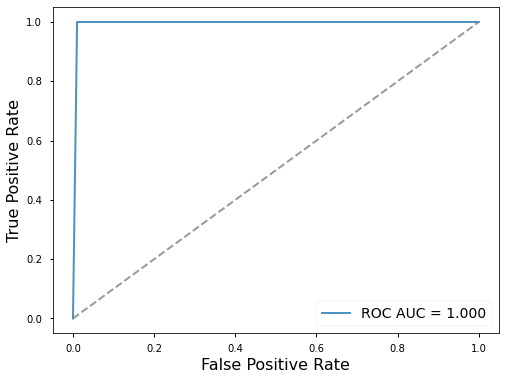

In [19]:
# 與前面範例相同的 pipeline 定義，假設超參數就是最佳
pipelr = Pipeline(
    steps=[
        ('zscaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=300))
    ]
)

# 直接訓練整個訓練集
pipelr.fit(X_train, Y_train)
# 已訓練模型用來預測測試集
Y_predict = pipelr.predict(X_test)

# confusion matrix
TN, FP, FN, TP = confusion_matrix(Y_test, Y_predict).ravel()
print('[Confusion Matrix]:\n  | TP: {} | FP: {} |\n  | FN: {} | TN: {} |\n'.format(TP, FP, FN, TN))

# sensitivity and specificity
sensitivity = recall_score(Y_test, Y_predict, pos_label=1)
specificity = recall_score(Y_test, Y_predict, pos_label=0)
print('[Testing Scores]:\n  * Sensitivity: {:.3f}\n  * Specificity: {:.3f}'.format(sensitivity, specificity))

# accuracy and ROC AUC
accuracy = accuracy_score(Y_test, Y_predict)
rocauc = roc_auc_score(Y_test, pipelr.predict_proba(X_test)[:,1])
print('  * Accuracy: {:.3f}\n  * ROC AUC: {:.3f}'.format(accuracy, rocauc))

# plot ROC curve
_, ax = plt.subplots(figsize=(8, 6))
fpr, tpr, _ = roc_curve(Y_test, pipelr.predict_proba(X_test)[:,1])
mean_fpr = np.linspace(0, 1, 100)
interp_tpr = np.interp(mean_fpr, fpr, tpr)
interp_tpr[0] = 0.0
ax.plot(mean_fpr, interp_tpr, label='ROC AUC = {:.3f}'.format(rocauc), lw=2, alpha=0.8)
# the diagonal line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='#808080', alpha=0.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.legend(loc="lower right", fontsize=14)
plt.show()

<a id="references"></a>

## References:

1. Scikit-Learn, "*User Guide*", scikit-learn.org, [[link]](https://scikit-learn.org/stable/user_guide.html).
